In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# extraindo o zip
import os
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/office_not_office')

In [4]:
# definindo os paths no /tmp da virtual machine do Colab
base_dir = '/tmp/office_not_office/dataset'
train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set')

In [5]:
# definindo set de treino
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(400, 400),
batch_size=32)

Found 450 files belonging to 2 classes.


In [6]:
# definindo set de teste
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(400, 400),
batch_size=32)

Found 170 files belonging to 2 classes.


In [7]:
# testando se o set de treino veio certinho. o output correto deve ser ['office', 'not_office']
class_names = training_set.class_names
class_names

['not_office', 'office']

In [8]:
# obtendo um modelo de aleatorizacao de imagens para evitar overfit
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(400, 400, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [9]:
# CNN com Dropout e BatchNormalization para acelerar o treino

model = Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    tf.keras.layers.BatchNormalization(),  # não tenho certeza se esta linha deveria vir antes ou depois do Dropout
    Dense(1, activation='sigmoid')
])

In [10]:
# Compilando o modelo
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [11]:
# Definindo callbacks para Early Stopping e para Checkpoints que salvam o melhor modelo
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=2),
             model_checkpoint_callback,
]

In [36]:
# Treinando o modelo

history = model.fit(training_set,validation_data=validation_set, epochs=600,callbacks=callbacks)

Epoch 1/600
15/15 [==============================] - 97s 6s/step - loss: 0.6212 - binary_accuracy: 0.6711 - val_loss: 0.6617 - val_binary_accuracy: 0.6647
Epoch 2/600
15/15 [==============================] - 96s 6s/step - loss: 0.5923 - binary_accuracy: 0.6600 - val_loss: 0.6178 - val_binary_accuracy: 0.6765
Epoch 3/600
15/15 [==============================] - 97s 6s/step - loss: 0.5545 - binary_accuracy: 0.7133 - val_loss: 0.5941 - val_binary_accuracy: 0.6941
Epoch 4/600
15/15 [==============================] - 97s 6s/step - loss: 0.5627 - binary_accuracy: 0.7111 - val_loss: 0.7123 - val_binary_accuracy: 0.5000
Epoch 5/600
15/15 [==============================] - 97s 6s/step - loss: 0.5490 - binary_accuracy: 0.6956 - val_loss: 0.8683 - val_binary_accuracy: 0.3824
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


In [13]:
# Plotando metricas
metrics_df = pd.DataFrame(history.history)

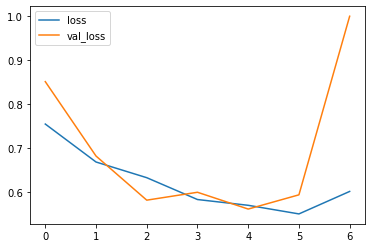

In [14]:
metrics_df[["loss","val_loss"]].plot();

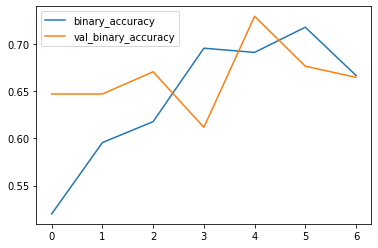

In [15]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot();

In [16]:
# Avaliação do modelo
loss, accuracy = model.evaluate(validation_set)
print('Accuracy on test dataset:', accuracy) 

6/6 [==============================] - 8s 1s/step - loss: 0.9988 - binary_accuracy: 0.6647
Accuracy on test dataset: 0.6647058725357056


In [24]:
import numpy as np
# pra pegar X_test  e y_test daqui
print(validation_set)
y_test = np.concatenate([y for x, y in validation_set], axis=0)
X_test = np.concatenate([x for x, y in validation_set], axis=0)
y_test

<BatchDataset shapes: ((None, 400, 400, 3), (None,)), types: (tf.float32, tf.int32)>


array([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0], dtype=int32)

In [25]:
X_test

array([[[[8.41250000e+01, 8.41250000e+01, 8.21250000e+01],
         [8.57500000e+01, 8.61250000e+01, 8.30000000e+01],
         [8.70000000e+01, 8.80000000e+01, 8.30000000e+01],
         ...,
         [3.37500000e+00, 5.37500000e+00, 3.75000000e-01],
         [4.00000000e+00, 6.00000000e+00, 1.00000000e+00],
         [3.12500000e+00, 5.12500000e+00, 1.25000000e-01]],

        [[8.58242188e+01, 8.58242188e+01, 8.54101562e+01],
         [8.59765625e+01, 8.60117188e+01, 8.39062500e+01],
         [8.66601562e+01, 8.73203125e+01, 8.33398438e+01],
         ...,
         [2.12890625e+00, 5.03515625e+00, 3.51562500e-02],
         [2.75390625e+00, 5.66015625e+00, 9.37500000e-02],
         [3.01171875e+00, 5.91796875e+00, 1.17187500e-02]],

        [[8.67382812e+01, 8.82148438e+01, 8.74375000e+01],
         [8.60000000e+01, 8.60000000e+01, 8.50546875e+01],
         [8.60976562e+01, 8.67226562e+01, 8.28476562e+01],
         ...,
         [3.68750000e+00, 6.68750000e+00, 0.00000000e+00],
         [

In [26]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [33]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

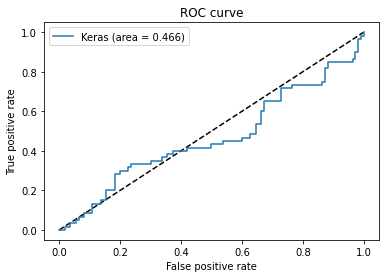

In [34]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()